BIGRU HR Specified

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import shap
from lime.lime_text import LimeTextExplainer
import string


KeyboardInterrupt: 

In [ ]:
data = pd.read_csv('C:/Users/sachu/Desktop/DB/dbhrats.csv')

# Basic data inspection

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7791 entries, 0 to 7790
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           7367 non-null   float64
 1   Resume_str   7367 non-null   object 
 2   Category     7367 non-null   object 
 3   title        7791 non-null   object 
 4   description  7791 non-null   object 
 5   ATS_Score    7791 non-null   float64
dtypes: float64(2), object(4)
memory usage: 365.3+ KB
None


        text_length   word_count
count   7791.000000  7791.000000
mean    6154.246695   780.080863
std     2695.876427   350.403747
min        3.000000     1.000000
25%     5215.000000   662.000000
50%     5764.000000   724.000000
75%     6926.000000   891.000000
max    17256.000000  2302.000000


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


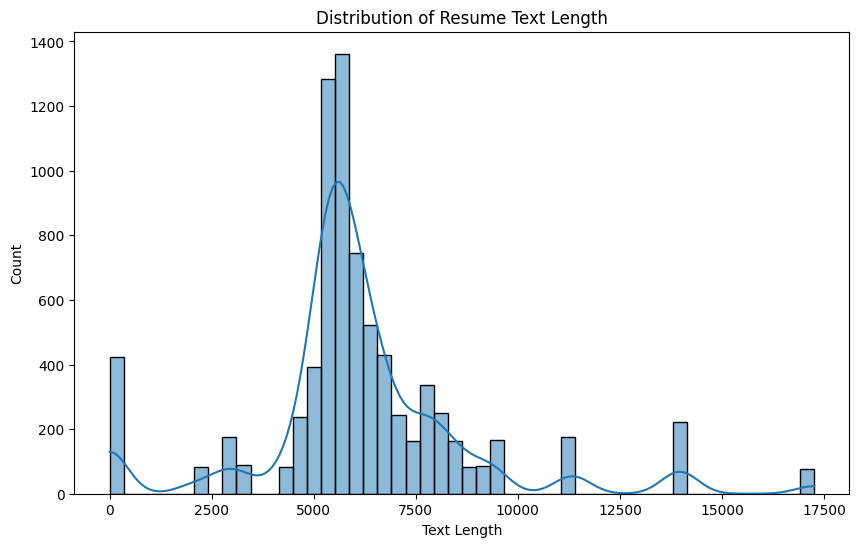

In [ ]:
# Text Statistics
data['text_length'] = data['Resume_str'].apply(lambda x: len(str(x)))
data['word_count'] = data['Resume_str'].apply(lambda x: len(str(x).split()))
print(data[['text_length', 'word_count']].describe())

# Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Resume Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()



# Handle missing values if any
data.dropna(inplace=True)

# Encode categorical variables like 'Category'
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

In [ ]:
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the English model
nlp = spacy.load("en_core_web_sm")


# Abbreviations dictionary for job market
abbreviations = {
    "mgr": "manager",
    "sr": "senior",
    "jr": "junior",
    "asst": "assistant",
    "assoc": "associate",
    "dept": "department",
    "exp": "experience",
    "hr": "human resources",
    "acct": "account",
    "acctg": "accounting",
    "fin": "finance",
    "eng": "engineer",
    "engg": "engineering",
    "it": "information technology",
    "qa": "quality assurance",
    "dev": "development",
    "devops": "development operations",
    "proj": "project",
    "mktg": "marketing",
    "biz": "business",
    "comm": "communication",
    "adm": "administration",
    "sec": "secretary",
    "exec": "executive",
    "corp": "corporation",
    "intl": "international",
    "rep": "representative",
    "mfg": "manufacturing",
    "prod": "production",
    "purch": "purchasing",
    "sales": "sales",
    "cust": "customer",
    "svc": "service",
    "tech": "technical",
    "sup": "supervisor",
    "supv": "supervision",
    "log": "logistics",
    "inv": "inventory",
    "sch": "schedule",
    "edu": "education",
    "lang": "language",
    "pr": "public relations",
    "hrd": "human resources development",
    "cfo": "chief financial officer",
    "ceo": "chief executive officer",
    "coo": "chief operating officer",
    "cmo": "chief marketing officer",
    "cto": "chief technology officer",
    "cio": "chief information officer",
    "pmo": "project management office",
    "pmp": "project management professional",
    "ba": "business analyst",
    "bpm": "business process management",
    "ui": "user interface",
    "ux": "user experience",
    "svp": "senior vice president",
    "vp": "vice president",
    "gm": "general manager",
    "doe": "depends on experience",
    "r&d": "research and development",
    "seo": "search engine optimization",
    "sem": "search engine marketing",
    "smm": "social media marketing",
    "b2b": "business to business",
    "b2c": "business to consumer",
    "kpi": "key performance indicator",
    "roi": "return on investment",
    "saas": "software as a service",
    "paas": "platform as a service",
    "iaas": "infrastructure as a service",
    "crm": "customer relationship management",
    "erp": "enterprise resource planning",
    "sd": "software development",
    "pm": "project manager",
    "pa": "personal assistant",
    "exec": "executive",
    "fin": "finance",
    "hrm": "human resources management",
    "it": "information technology",
    "pr": "public relations",
    "qa": "quality assurance",
    "r&d": "research and development",
    "scm": "supply chain management",
    "seo": "search engine optimization",
    "smm": "social media marketing",
    "ux": "user experience",
    "ui": "user interface",
    "bi": "business intelligence",
    "dev": "development",
    "ops": "operations"
}


def expand_abbreviations(text, abbreviations):
    for abbr, expanded in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(abbr), expanded, text)
    return text

def clean_and_preprocess(text):
    text = expand_abbreviations(text, abbreviations)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(tokens)

def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    return nouns

# Apply cleaning and preprocessing
data['processed_resume'] = data['Resume_str'].apply(clean_and_preprocess)
data['processed_description'] = data['description'].apply(clean_and_preprocess)

# Extract nouns and combine processed text
data['nouns'] = data.apply(lambda row: extract_nouns(row['processed_resume'] + ' ' + row['processed_description']), axis=1)

# Ensure 'nouns' column is populated with lists
print(data['nouns'].head())

# Convert list of nouns to string
data['nouns_str'] = data['nouns'].apply(lambda x: ' '.join(x))

# Tokenizer and sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['nouns_str'])

nouns_sequences = tokenizer.texts_to_sequences(data['nouns_str'])
max_nouns_length = 10  # Adjust based on your data
nouns_data = pad_sequences(nouns_sequences, maxlen=max_nouns_length)

# Now you can use `nouns_data` in your model
print(nouns_data)
# Extract nouns and combine processed text

data['combined_text'] = data['processed_resume'] + ' ' + data['processed_description']
print(data['combined_text'].head())


0    [hr, clerk, summary, team, orient, policy, dri...
1    [summary, communication, skill, experience, to...
2    [summary, hr, generalist, experience, employee...
3    [hr, manager, resource, ability, work, organiz...
4    [assistantoffice, assistant, summary, communic...
Name: nouns, dtype: object
[[  78   47  689 ...  699    6   59]
 [ 399  375  350 ...  258  341  797]
 [1883  123   55 ...    4   58  156]
 ...
 [  39   56 3387 ...  113 3389   56]
 [ 343   59 1701 ...  920  917  209]
 [1252  787    2 ...   59  328  430]]
0    hr clerk summary ethical team orient policy dr...
1    hr generalist summary peopleoriented resultsdr...
2    hr generalist summary hr generalist yrs profes...
3    hr manager summary human resource professional...
4    general hr assistantoffice assistant summary e...
Name: combined_text, dtype: object


In [ ]:
# Tokenize combined text
tokenizer.fit_on_texts(data['combined_text'].values.tolist())

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['combined_text'].values)
word_index = tokenizer.word_index

# Padding sequences
max_sequence_length = 1500
data_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Target variable
y = data['ATS_Score'].values

print(data_padded.shape)
print(y.shape)

(7367, 1500)
(7367,)


In [ ]:
from sklearn.model_selection import train_test_split


# Split the data
# X_train_data, X_val_data, X_train_nouns, X_val_nouns, y_train, y_val = train_test_split(
#     data, nouns_data, labels, test_size=0.2, random_state=42
# )
X_train, X_test, X_train_nouns, X_test_nouns, y_train, y_test = train_test_split(data_padded, nouns_data,y, test_size=0.2, random_state=42)
X_train, X_val, X_train_nouns, X_val_nouns, y_train, y_val = train_test_split(X_train, X_train_nouns, y_train, test_size=0.2, random_state=42)
# Check shapes after splitting
print(f"X_train_data shape: {X_train.shape}")
print(f"X_train_nouns shape: {X_train_nouns.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val_data shape: {X_val.shape}")
print(f"X_val_nouns shape: {X_val_nouns.shape}")
print(f"y_val shape: {y_val.shape}")

X_train_data shape: (4714, 1500)
X_train_nouns shape: (4714, 10)
y_train shape: (4714,)
X_val_data shape: (1179, 1500)
X_val_nouns shape: (1179, 10)
y_val shape: (1179,)


In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, concatenate, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# Model Inputs
text_input = Input(shape=(max_sequence_length,), name='text_input')
nouns_input = Input(shape=(10,), name='nouns_input')

# Embedding Layer
embedding_dim = 100  # Adjust based on your embedding size
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length)(text_input)

# Apply Spatial Dropout
embedded_dropout = SpatialDropout1D(0.2)(embedding_layer)

# Bidirectional GRU Layer
gru = Bidirectional(GRU(128, return_sequences=True, dropout=0.3))(embedded_dropout)

# Global Average Pooling
gru_pool = GlobalAveragePooling1D()(gru)

# Dense Layers for Nouns Input
nouns_dense = Dense(32, activation='relu')(nouns_input)

# Combine GRU output with nouns dense layer
combined = concatenate([gru_pool, nouns_dense])

# Additional Dense Layers with Regularization
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layer
output = Dense(1, activation='linear')(x)

# Model definition
model = Model(inputs=[text_input, nouns_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 1500)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1500, 100) │    764,800 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 1500, 100) │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1500, 256) │    176,640 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nouns_input         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        352 │ nouns_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 288)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     18,496 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 962,401 (3.67 MB)

 Trainable params: 962,401 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

: 

In [ ]:
# X_combined = np.concatenate([X_resume, X_description], axis=-1)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Define callbacks for early stopping, learning rate reduction, and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Training the modified model
history = model.fit(
    [X_train, X_train_nouns], y_train,
    epochs=10,  # Example value, can be adjusted
    batch_size=64,  # Example value, can be adjusted
    validation_data=([X_val, X_val_nouns], y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([X_test, X_test_nouns], y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 345s 5s/step - loss: 16699.5527 - mae: 91.2370 - val_loss: 1820.4232 - val_mae: 38.1428 - learning_rate: 0.0010
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 348s 5s/step - loss: 2261.7617 - mae: 39.3702 - val_loss: 1289.3793 - val_mae: 31.6052 - learning_rate: 0.0010
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 378s 5s/step - loss: 1486.1840 - mae: 31.5696 - val_loss: 871.5233 - val_mae: 25.6961 - learning_rate: 0.0010
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 379s 5s/step - loss: 1085.7312 - mae: 26.6872 - val_loss: 611.6718 - val_mae: 21.2148 - learning_rate: 0.0010
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 340s 5s/step - loss: 862.3350 - mae: 23.8808 - val_loss: 486.1691 - val_mae: 18.8810 - learning_rate: 0.0010
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 376s 5s/step - loss: 793.0415 - mae: 22.6835 - val_loss: 435.1261 - val_mae: 17.8168 - learning_rate: 0.0010
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - loss: 694.3508 - mae: 21.2383 - val_loss: 351.7408 - val_m

In [ ]:
# Save the entire model to a file
model.save('bigruhr.keras')

NameError: name 'model' is not defined

In [ ]:
# Plot training history
import matplotlib.pyplot as plt


# Get history data from the History object
history_dict = history.history

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()
